In [11]:
%run ../preprocessing/Artifact_Removal/preprocecssing_helpers.ipynb
%run ../preprocessing/StimCodes.ipynb
%run ../preprocessing/Artifact_Removal/Batch_ArtifactFilter_Epoch.ipynb
%run ../Classification/ConcatEpochTrails.ipynb
%run ../preprocessing/Artifact_Removal/Extract_Describer_Events.ipynb
import os

import mne
from mne.baseline import rescale
from mne.stats import _bootstrap_ci

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib qt
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
matplotlib.rcParams.update({'font.size': 15})

ERROR:root:File `'preprocecssing_helpers.ipynb.py'` not found.
ERROR:root:File `'preprocecssing_helpers.ipynb.py'` not found.
ERROR:root:File `'Batch_ArtifactFilter_Epoch.ipynb.py'` not found.


In [2]:
path = 'D:\stim_code_epochs'
epoch_files = os.listdir(path)

In [4]:
np.random.seed(42)
n = np.random.randint(0,len(epoch_files))
print(n)

6


In [5]:
epoch = mne.read_epochs(os.path.join(path, epoch_files[n]), preload = True)

Reading D:\stim_code_epochs\20140207_1219_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    1949.22 ms
        0 CTF compensation matrices available
940 matching events found
Applying baseline correction (mode: mean)
940 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [6]:
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

In [9]:
# reduce dimensions of n_times to a point for each band.
montage = mne.channels.read_montage(kind = 'ANT_DukeWaveGuard_128_electrode_montages_updated_V4')
epoch.set_montage(montage);
if 'Nasium' in epoch.ch_names:
    epoch.drop_channels(ch_names=['Nasium', 'LL4', 'L12', 'VEOG']);

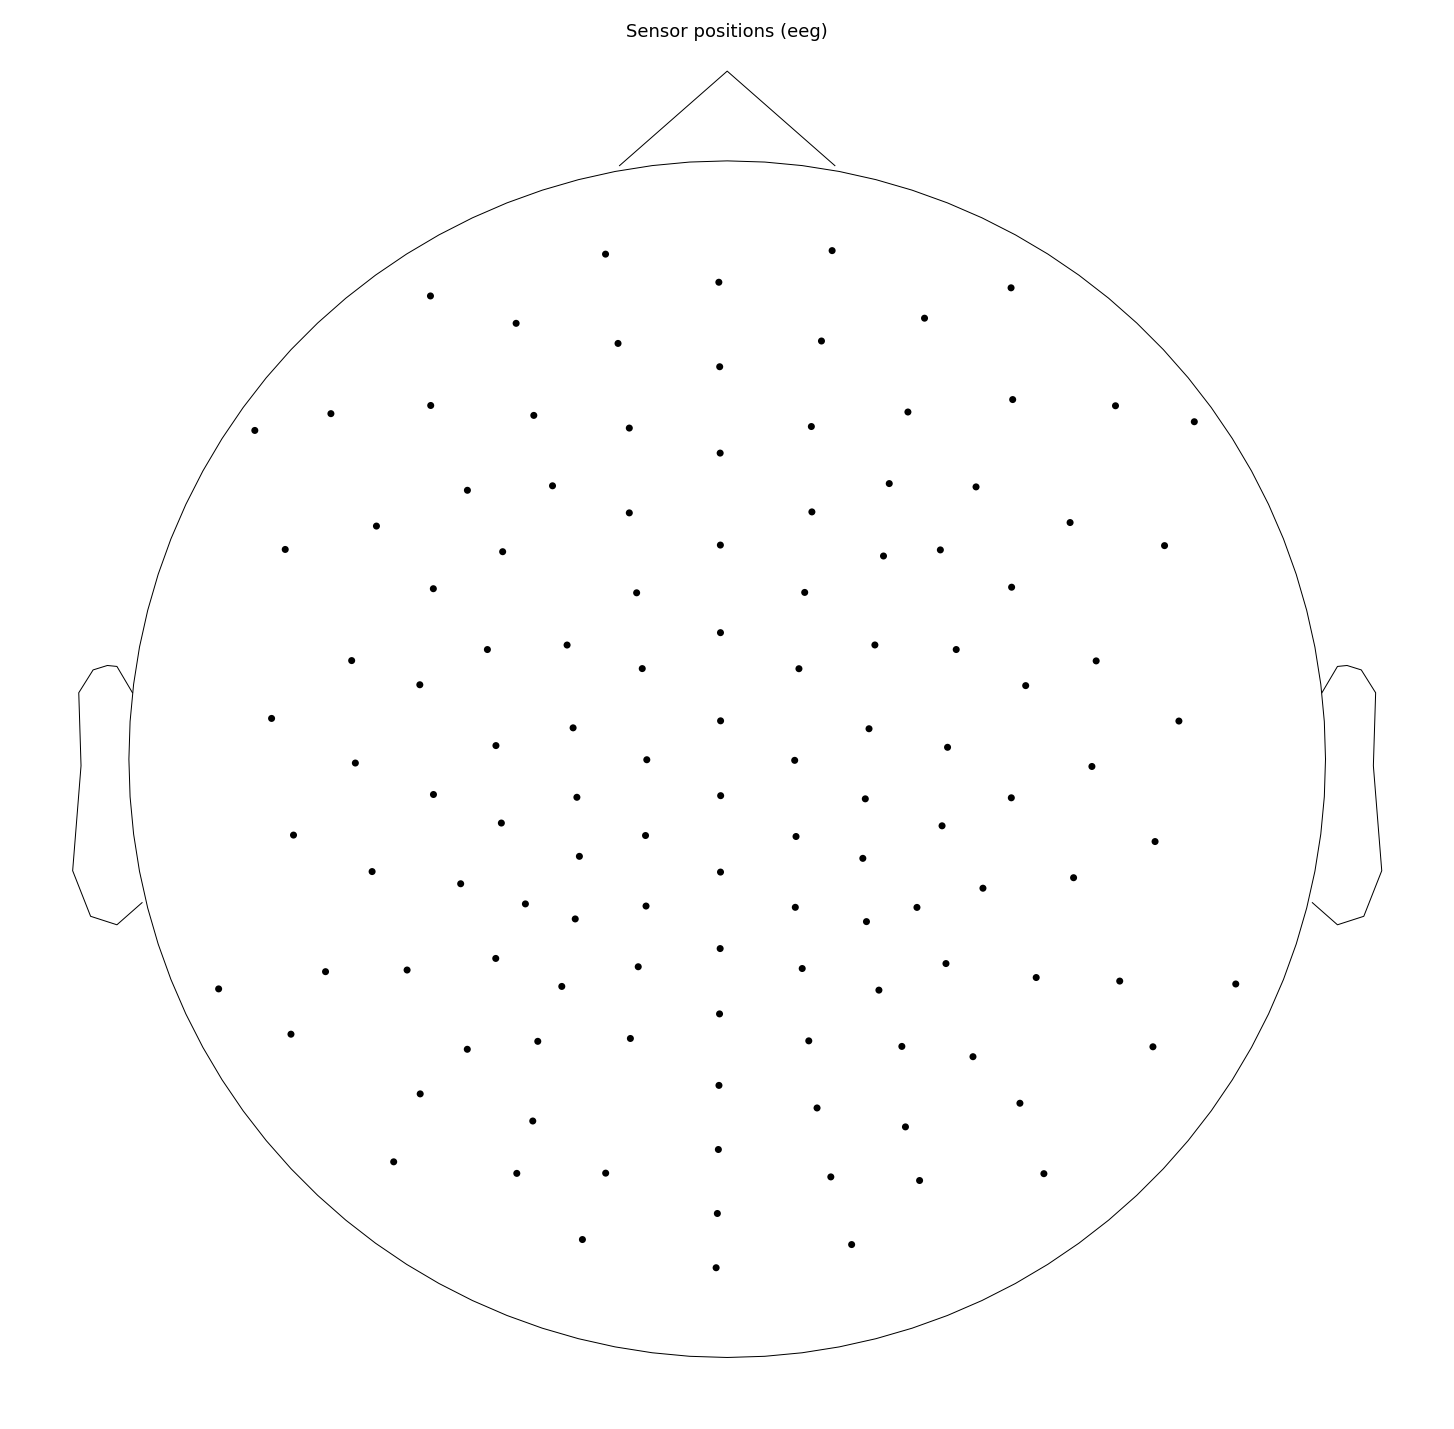

In [13]:
epoch.plot_sensors();

In [ ]:

frequency_map = list()
frequency_data = list()
for band, fmin, fmax in iter_freqs:
    epoch = mne.read_epochs(os.path.join(path, epoch_files[n]), preload = True)
    epoch.drop_channels(['Nasium','Lm','Rm','VEOG'])
    filtered_epoch = epoch.filter(fmin, fmax, n_jobs=1,
                                    l_trans_bandwidth = 1,
                                    h_trans_bandwidth = 1,
                                    fir_design = 'firwin')
    filtered_epoch.subtract_evoked()
    filtered_epoch = mne.EpochsArray(filtered_epoch.get_data(), info = filtered_epoch.info,
                                      tmin = filtered_epoch.tmin, events = filtered_epoch.events)
    frequency_map.append(((band,fmin,fmax), filtered_epoch.average()))
    frequency_data.append(((band,fmin,fmax), filtered_epoch))
    

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = _bootstrap_ci(average.data, random_state=0,
                                  stat_fun=lambda x: np.sum(x ** 2, axis=0))
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-1000, 3000)

axes.ravel()[-1].set_xlabel('Time [ms]')

In [ ]:
gamma_epoch = frequency_data[- 1][-1]

In [ ]:
# classify using gamma data and theta data because it has the most spikes
epoch_trials = get_epoch_trials(gamma_epoch)
# convert_event_ids_to_stim_combinations(gamma_epoch,trial_index_list, stim_combinations)
np.array(epoch_trials[0])[:,-1]

In [ ]:
new_events = convert_epoch_events_to_stim_combinations(epoch_object = gamma_epoch)
# new_events[:100]

In [ ]:
trial = np.array(epoch_trials[0])
trial[:,-1] = 1
trial

In [ ]:
epoch.events